
# <center> **UNET** </center>



## <span style="color:red"> Outline </span>
1. [**Semantic segmentation**](#Semant_seg)
2. [**UNET: an autoencoder for segmentation**](#Unet)
3. [**UNET application 1**](#Unet_1)
4. [**UNET application 2**](#Unet_2)


In [1]:
#@title **Student:** Mount the Drive  (If you are in colab)
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/')
print(os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive


In [2]:
#@title **Load libraries**
#@markdown Here is important to change to GPU

import os
import cv2
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook, tnrange

from itertools import chain
from skimage.morphology import label
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from skimage.io import imread, imshow, concatenate_images

import tensorflow as tf
from keras.optimizers import Adam
from keras.models import Model, load_model
from keras.layers import concatenate, add
from keras.layers import Dense, Activation, Dropout, Reshape, Permute ## cambio
from keras.layers import Conv2D, Conv2DTranspose
from keras.layers import MaxPooling2D, GlobalMaxPool2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator  #img_to_array, array_to_img, load_img

# **1. Semantic segmentation** <a name="Semant_seg"></a>

Image classification gives a **discrete labeled answer (image dimension)** from an image input with **objects of interest** into a particular scene. This task is much more complex, including localization, detection, and spatial object boundary.

For **_semantic segmentation_** specifically the task is associated **to each pixel** with a semantic label produced by a machine learning algorithm. This task is known as a **dense prediction** and the result is useful for many different scenarios, areas and applications. In figure you can observe applications related with **autonomous vehicles** for planning and detection of traffic signs, to support **biomedical image diagnosis**, for **agriculture precision** to reduce herbicides and smart control.

<center>
<img src="https://github.com/wDavid98/IA-docs/blob/main/data/Unet/segmentation.png?raw=true" style="width:700px;heigth:100px">
</center>

Nowadays, there exist more sophisticated models that try **instance segmentation** with the idea to obtain a per-pixel segmentation but for **multiclass** problems.

# **2. UNET: an autoencoder to segmentation** <a name="Unet"></a>

### **Transposed deconvolution**

This is a special module on UNET also named deconvolution or fractionally strided convolution.

- How convolution works (with no padding)?

<center>
<img src="https://github.com/wDavid98/IA-docs/blob/main/data/Unet/convolucion.png?raw=true" width="400">
</center>

- How to deconvolve? (from [4](https://medium.com/activating-robotic-minds/up-sampling-with-transposed-convolution-9ae4f2df52d0))

We want to go backward and reproduce the original input for this special autoencoder, in one-to-many relationships.


<center>
<img src="https://github.com/wDavid98/IA-docs/blob/main/data/Unet/deconvolution.png?raw=true" width="400">
</center>

The main idea behind this is **transposed convolution**. For doing so, we need to rearrange the kernel matrix and understand convolution as a linear matricial operation, as:

1. Convolution as matricial operation: re-arrange kernel matrix

<center>
<img src="https://github.com/wDavid98/IA-docs/blob/main/data/Unet/conv_mat.png?raw=true" width="800">
</center>

Pay attention that original image is ($4 \times 4$) and kernel is ($3 \times 3$))
2. Transpose such an operation to obtain deconvolution.

<center>
<img src="https://github.com/wDavid98/IA-docs/blob/main/data/Unet/deconv_mat.png?raw=true" width="500">
</center>



### **The architecture of UNET**

<center>
<img src="https://github.com/wDavid98/IA-docs/blob/main/data/Unet/unet.png?raw=true"  width="700">
</center>
So, how looks an UNET-code... **go to the action!**

In [3]:
#@title **Coding** Create the pair of UNET convolutions
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # First layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)

    x = Activation('relu')(x)

    # Second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x


In [4]:
 #@title **Coding** A nice UNET function
 def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):

    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)

    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)

    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)

    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)

    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)

    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)

    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

# **3. UNET application 1**  <a name="Unet_1"></a>
### **Nuclei segmentation**

A very important task is automate nucleus detection and segmentation. The task of classifying, identifying, and segmenting cell nuclei is very important in many clinical tasks, such as: quantifying disorders, diseases related to cancer, understand treatment responses, among others. The image data was taken from [data-science-bowl-2018](https://www.kaggle.com/c/data-science-bowl-2018)

<center>
<img src="https://storage.googleapis.com/kaggle-media/competitions/dsb-2018/dsb.jpg" width="700">
</center>





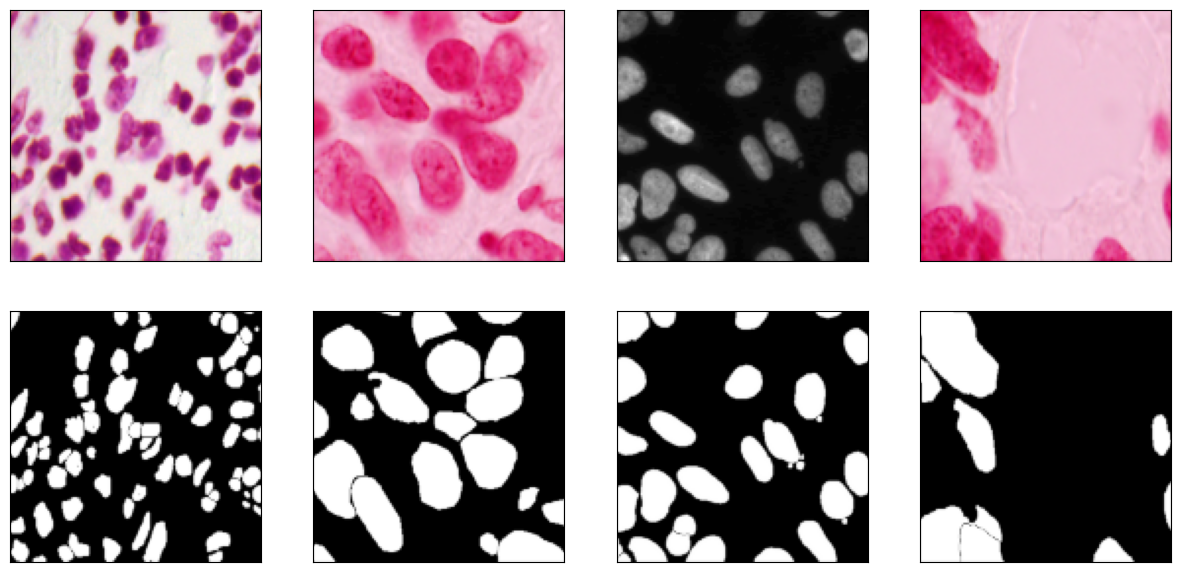

In [5]:
#@title **Coding** Let's show some examples
path = '/content/drive/MyDrive/Academia40/Notebooks/data/bowl-2018/'

plt.figure(figsize=(15,15))
plt.subplot(441), plt.imshow(cv2.imread(os.path.join(path,'imgs', '71.png'),)), plt.xticks([]), plt.yticks([]);
plt.subplot(442), plt.imshow(cv2.imread(os.path.join(path,'imgs', '68.png'))), plt.xticks([]), plt.yticks([]);
plt.subplot(443), plt.imshow(cv2.imread(os.path.join(path,'imgs', '94.png'))),plt.xticks([]), plt.yticks([]);
plt.subplot(444), plt.imshow(cv2.imread(os.path.join(path,'imgs', '114.png'))),plt.xticks([]), plt.yticks([]);
plt.subplot(445), plt.imshow(cv2.imread(os.path.join(path,'masks', '71.png'))), plt.xticks([]), plt.yticks([]);
plt.subplot(446), plt.imshow(cv2.imread(os.path.join(path,'masks', '68.png'))), plt.xticks([]), plt.yticks([]);
plt.subplot(447), plt.imshow(cv2.imread(os.path.join(path,'masks', '94.png'))),plt.xticks([]), plt.yticks([]);
plt.subplot(448), plt.imshow(cv2.imread(os.path.join(path,'masks', '114.png'))),plt.xticks([]), plt.yticks([]);


In [6]:
#@title **Coding** To load the dataset
# path = '/content/drive/MyDrive/2024-2/IA2/Inteligencia Artificial -  II/ai-2-uis-student/data/bowl-2018/'
# Create each array of the images and the corresponding mask
imgs_l = []; masks_l =[]

# List them all
imgs = os.listdir(path + 'imgs')
masks = os.listdir(path + 'masks')

# Time to sort
imgs.sort(); masks.sort()

# How can we obtain each path?
imgs = [os.path.join(path, 'imgs', img) for img in imgs]
masks = [os.path.join(path, 'masks', mask) for mask in masks]

# Load each image
imgs_l = [cv2.imread(img) for img in imgs]
masks_l = [cv2.imread(mask,0) for mask in masks]

# Normalize all the data
print("Images: ", len(imgs_l), "Masks: ",  len(masks_l), "Shape of an specific image: ", imgs_l[0].shape)
X = np.array(imgs_l)/255.0
y = np.array(masks_l)/255.0
print("X samples value: ", X.shape, "Y samples value: ", y.shape, "Max value on X: ", np.max(X), "Min value on X", np.min(X))
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

Images:  670 Masks:  670 Shape of an specific image:  (128, 128, 3)
X samples value:  (670, 128, 128, 3) Y samples value:  (670, 128, 128) Max value on X:  1.0 Min value on X 0.0


In [7]:
#@title **Coding** Charge, prepare and tune the model
input_img = Input((128, 128, 3), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ img (InputLayer)          │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 16)   │            448 │ img[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 128, 128, 16)   │             64 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 128, 128, 16)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 16)     │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 64, 64, 16)     │              0 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 32)     │          4,640 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 64, 64, 32)     │            128 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 64, 64, 32)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 32)     │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 32, 32, 32)     │              0 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 64)     │         18,496 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 32, 32, 64)     │            256 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_5 (Activation) │ (None, 32, 32, 64)     │              0 │ batch_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 16, 16, 64)     │              0 │ activation_5[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 16, 16, 64)     │              0 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)    

 Total params: 1,179,409 (4.50 MB)

 Trainable params: 1,177,937 (4.49 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [8]:
#@title **Coding** Time to train the model! :)
earlystopper = EarlyStopping(patience=3, verbose=1)
#checkpointer = ModelCheckpoint('model_cell_unet.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, y_train, batch_size=32,
                    callbacks=[earlystopper],
                    epochs=50,validation_data=(X_valid, y_valid))


Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.7154 - loss: 0.5265 - val_accuracy: 0.6981 - val_loss: 0.5952
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.8307 - loss: 0.3031 - val_accuracy: 0.6462 - val_loss: 0.6752
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.8524 - loss: 0.2214 - val_accuracy: 0.6980 - val_loss: 0.9422
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.8594 - loss: 0.1840 - val_accuracy: 0.8596 - val_loss: 0.2402
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.8603 - loss: 0.1633 - val_accuracy: 0.8535 - val_loss: 0.2009
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.8596 - loss: 0.1527 - val_accuracy: 0.8599 - val_loss: 0.1712
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.8610 - loss: 0.1489 - val_accuracy: 0.8496 - val_loss: 0.1751
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.8586 - loss: 0.1381 - val_accuracy: 0.8452 - va

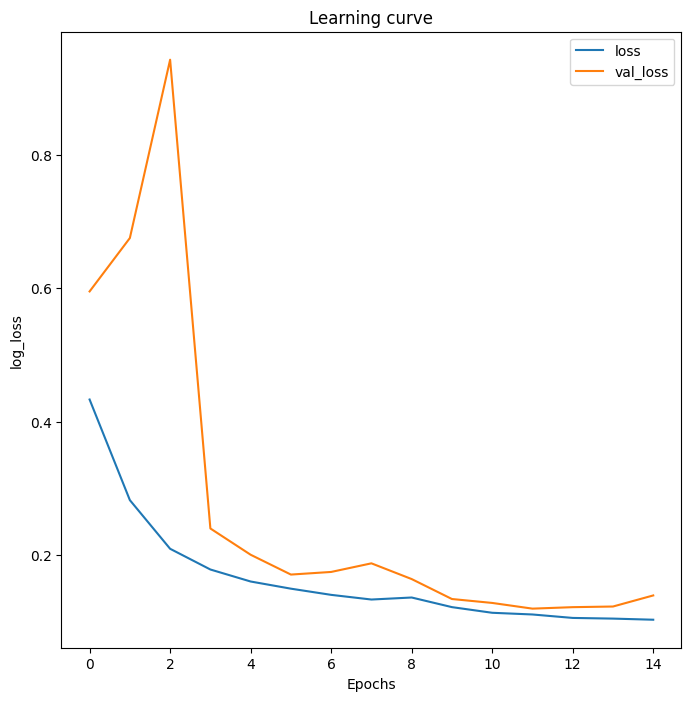

In [9]:
#@title **Coding** To show train and test performance
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [10]:
model.save('/content/drive/MyDrive/Academia40/Notebooks/models/model_cell_unet.h5')

In [11]:
# If the model takes too long:
new_model2 = tf.keras.models.load_model('/content/drive/MyDrive/Academia40/Notebooks/models/model_cell_unet.h5')

In [12]:
#@title **Coding** What about each prediction?
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

preds_val.shape, preds_train.shape
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 316ms/step


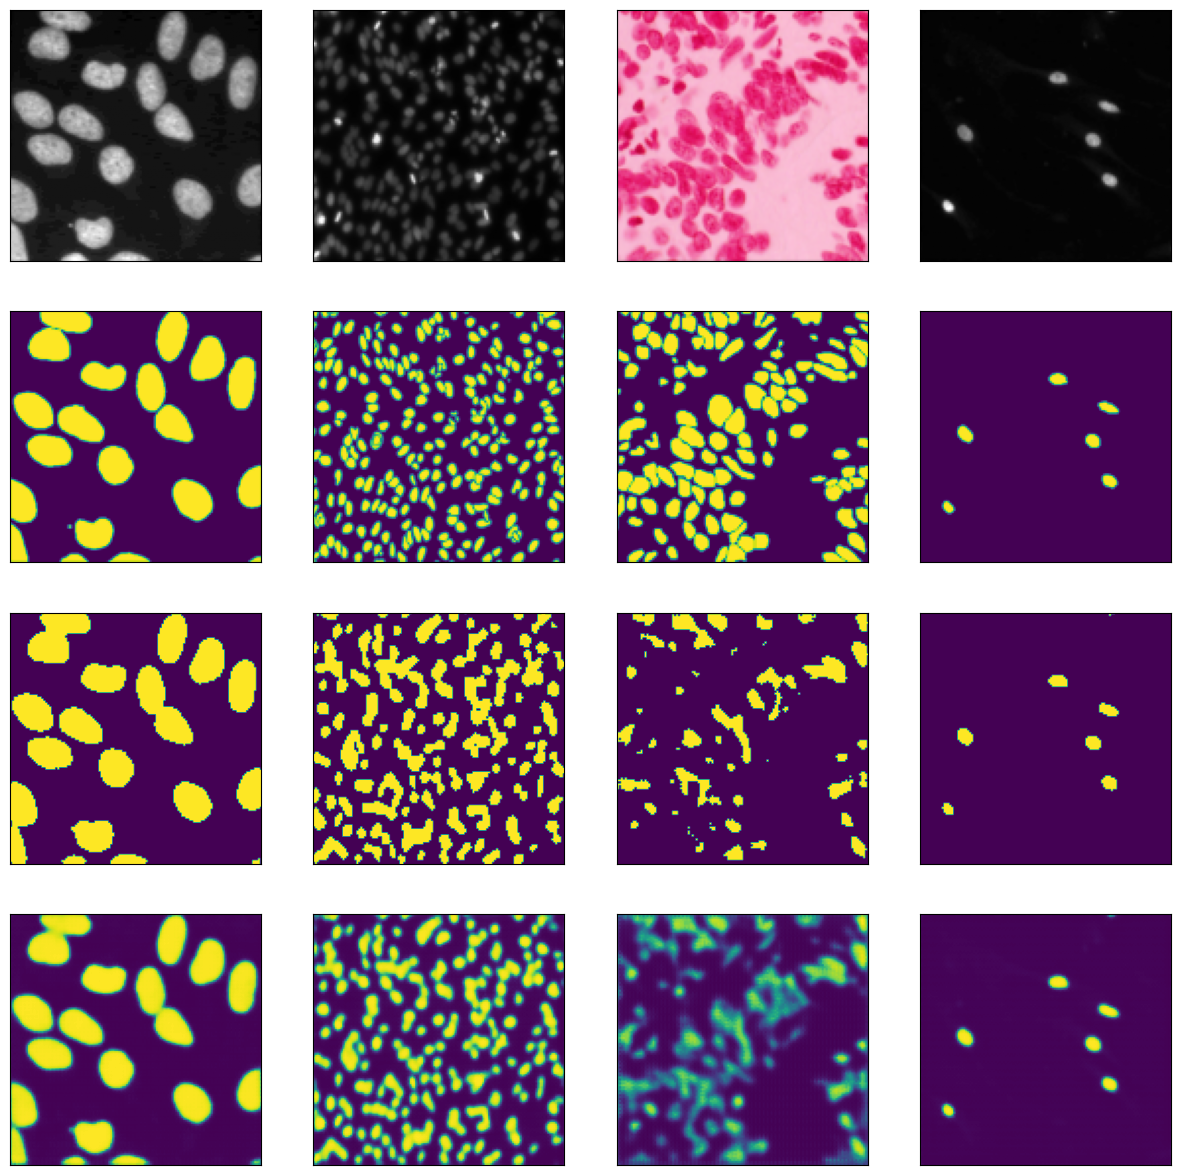

In [13]:
#@title **Coding** Some results
ex_1 =  21#@param {type:"integer"}
ex_2 = 15 #@param {type:"integer"}
ex_3 = 23 #@param {type:"integer"}
ex_4 =  50 #@param {type:"integer"}

plt.figure(figsize=(15,15))

plt.subplot(441), plt.imshow(X_valid[ex_1]), plt.xticks([]), plt.yticks([]);
plt.subplot(442), plt.imshow(X_valid[ex_2]), plt.xticks([]), plt.yticks([]);
plt.subplot(443), plt.imshow(X_valid[ex_3]), plt.xticks([]), plt.yticks([]);
plt.subplot(444), plt.imshow(X_valid[ex_4]), plt.xticks([]), plt.yticks([]);

plt.subplot(445), plt.imshow(y_valid[ex_1]), plt.xticks([]), plt.yticks([]);
plt.subplot(446), plt.imshow(y_valid[ex_2]), plt.xticks([]), plt.yticks([]);
plt.subplot(447), plt.imshow(y_valid[ex_3]), plt.xticks([]), plt.yticks([]);
plt.subplot(448), plt.imshow(y_valid[ex_4]), plt.xticks([]), plt.yticks([]);

plt.subplot(449), plt.imshow(np.squeeze(preds_val_t[ex_1])), plt.xticks([]), plt.yticks([]);
plt.subplot(4,4,10), plt.imshow(np.squeeze(preds_val_t[ex_2])), plt.xticks([]), plt.yticks([]);
plt.subplot(4,4,11), plt.imshow(np.squeeze(preds_val_t[ex_3])), plt.xticks([]), plt.yticks([]);
plt.subplot(4,4,12), plt.imshow(np.squeeze(preds_val_t[ex_4])), plt.xticks([]), plt.yticks([]);

plt.subplot(4,4,13), plt.imshow(np.squeeze(preds_val[ex_1])), plt.xticks([]), plt.yticks([]);
plt.subplot(4,4,14), plt.imshow(np.squeeze(preds_val[ex_2])), plt.xticks([]), plt.yticks([]);
plt.subplot(4,4,15), plt.imshow(np.squeeze(preds_val[ex_3])), plt.xticks([]), plt.yticks([]);
plt.subplot(4,4,16), plt.imshow(np.squeeze(preds_val[ex_4])), plt.xticks([]), plt.yticks([]);

**CHALLENGE**

- Try a more restrictive data learning. Only take 50 % and 20% of training data. Visualize and analyze the results. What happened?


# **Some conclusions**

- Nowadays, the UNet is one of the most representative architectures to segment images from a deep learning perspective, with impressive results in many areas.

- Of course, there exist many variations of this architecture to solve some segmentation challenges.

- Also, there exist other tasks are recognition, multiple instance segmentation that requires more sophisticated nets.

# **References**

[1. U-Net: Convolutional Networks for Biomedical
Image Segmentation](https://arxiv.org/pdf/1505.04597.pdf)


[2. A guide to convolution arithmetic for deep learning](https://arxiv.org/abs/1603.07285)

[3. Deconvolution and Checkerboard Artifacts](https://distill.pub/2016/deconv-checkerboard/)

[4. Transposed convolution](https://medium.com/activating-robotic-minds/up-sampling-with-transposed-convolution-9ae4f2df52d0)